<a href="https://colab.research.google.com/github/lmichan/BIOliteraturaPE203625/blob/main/Enlace_con_Zotero.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Análisis de la Biblioteca Zotero - Biología 2025

Este cuaderno de Google Colab fue desarrollado por José Antonio Hernández Mondragón como parte del proyecto PAPIME PE203625.

El propósito principal de este código es realizar un análisis detallado de la biblioteca Zotero correspondiente al curso de Biología 2025, con el fin de extraer información relevante, identificar patrones de uso, temáticas predominantes y apoyar la toma de decisiones en la gestión y mejora de los recursos bibliográficos disponibles.

A lo largo del cuaderno se implementan herramientas de procesamiento de datos, visualización y análisis bibliométrico para obtener una visión integral del contenido y estructura de la biblioteca Zotero.

## Conexión entre Zotero y Google Colab

Para realizar el análisis de la biblioteca de Zotero desde Google Colab, es necesario establecer una conexión entre ambas plataformas utilizando la Zotero Web API. Esta API permite acceder a colecciones, referencias, metadatos y otros recursos almacenados en una cuenta o grupo de Zotero, lo cual facilita el procesamiento automatizado de los datos.

## Requisitos de configuración

Antes de comenzar el análisis, es necesario contar con dos elementos clave:

* Zotero API Key

* Group ID (en caso de trabajar con una biblioteca de grupo)

### 1. Zotero API Key

La API Key es una clave personal que otorga permisos para acceder a la biblioteca Zotero de forma segura. Para obtenerla, sigue estos pasos:

* Accede a tu cuenta en Zotero.org.

* Ve a Settings > Feeds/API.

* En la sección de API Keys, haz clic en Create new private key.

* Define los permisos de acceso (por ejemplo, lectura) y copia la clave generada.

* Esta clave se utilizará en el código para autenticar las solicitudes a la API.

### 2. Group ID

Si estás trabajando con una biblioteca de grupo, también necesitas el identificador único del grupo. Para obtenerlo:

* Ingresa al sitio de Zotero y selecciona tu grupo.

* El Group ID se encuentra en la URL del grupo. Por ejemplo, en: https://www.zotero.org/groups/1234567/nombre_del_grupo

* El número 1234567 es el Group ID que deberás usar.


In [1]:
# CONFIGURA TU CLAVE Y GROUP ID

import requests
from collections import defaultdict, Counter
from datetime import datetime
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from wordcloud import WordCloud
import random

# Instalar la librería squarify para Treemaps
!pip install squarify

# Si es necesario se instala la libreria.
# !pip install wordcloud matplotlib
!pip install pyspellchecker

# CONFIGURA TU CLAVE Y GROUP ID (Estos se obtienen en Zotero)
API_KEY = "l7nkDwrKLxASVprKSjbadbXs"
GROUP_ID = "5866354"
HEADERS = {"Zotero-API-Key": API_KEY}


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.2/7.2 MB 47.4 MB/s eta 0:00:00


In [2]:
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
import os

# Configurar la fuente global de Matplotlib a una fuente serif disponible en Colab
try:
    # Usamos 'DejaVu Serif' como una alternativa común a Times New Roman en entornos como Colab
    plt.rcParams["font.family"] = "serif"
    plt.rcParams["font.serif"] = ["DejaVu Serif"]
    print("✅ Fuente de Matplotlib configurada a DejaVu Serif (o fuente serif predeterminada).")
except Exception as e:
    print(f"⚠️ No se pudo configurar la fuente serif. Error: {e}")
    print("Intentando usar la fuente serif predeterminada del sistema.")
    try:
        plt.rcParams["font.family"] = "serif"
        plt.rcParams["font.serif"] = ["serif"] # Fallback a la familia serif genérica
        print("✅ Fuente de Matplotlib configurada a la familia serif predeterminada.")
    except Exception as fallback_e:
         print(f"⚠️ Tampoco se pudo configurar la familia serif genérica. Error: {fallback_e}")
         print("Las gráficas podrían usar la fuente predeterminada de Matplotlib.")


✅ Fuente de Matplotlib configurada a DejaVu Serif (o fuente serif predeterminada).


In [3]:
import requests
import pandas as pd

API_KEY = "l7nkDwrKLxASVprKSjbadbXs"  # Tu clave
GROUP_ID = "5866354"
HEADERS = {"Zotero-API-Key": API_KEY}

items = []
url = f"https://api.zotero.org/groups/{GROUP_ID}/items?limit=100"

while url:
    response = requests.get(url, headers=HEADERS)
    if response.status_code != 200:
        print("❌ Error:", response.status_code)
        break

    data = response.json()
    if not data:
        break

    for item in data:
        if "data" in item:
            d = item["data"]
            tags = [t["tag"] for t in d.get("tags", [])]

            items.append({
                "titulo": d.get("title"),
                "fecha_publicacion": d.get("date"),  # 👈 Usa el año o fecha de publicación real
                "tipo": d.get("itemType"),
                "etiquetas": tags,
                "fecha": d.get("dateAdded"), # 👈 Fecha de adición
                "lugar": d.get("place"), # 👈 Añadir campo 'place'
                "editorial": d.get("publisher"), # 👈 Añadir campo 'publisher'
                "extra": d.get("extra"), # 👈 Añadir campo 'extra'
                "url": d.get("url"), # 👈 Ensure 'url' is included
                "language": d.get("language"), # 👈 Add language field
                "ISBN": d.get("ISBN"), # 👈 Add ISBN field
                "DOI": d.get("DOI") # 👈 Add DOI field

            })

    # Manejo de paginación automática
    if "Link" in response.headers:
        links = response.headers["Link"].split(",")
        next_link = None
        for link in links:
            if 'rel="next"' in link:
                next_link = link[link.find("<")+1:link.find(">")]
        url = next_link
    else:
        url = None

# Crear DataFrame
df = pd.DataFrame(items)
print(f"✅ Se descargaron {len(df)} ítems")
# Suprimir la visualización automática del DataFrame
# display(df.head())

✅ Se descargaron 1177 ítems


La paleta de colores utilizada para este trabajo es Okabe-Ito fue propuesta por Okabe e Ito (2008) como una paleta de colores cualitativa accesible para personas con diversas deficiencias en la visión del color. Además de ser accesible, incluye nueve colores vivos y fáciles de identificar, que corresponden a los principales colores primarios y secundarios (p. ej., rojo, amarillo y azul).

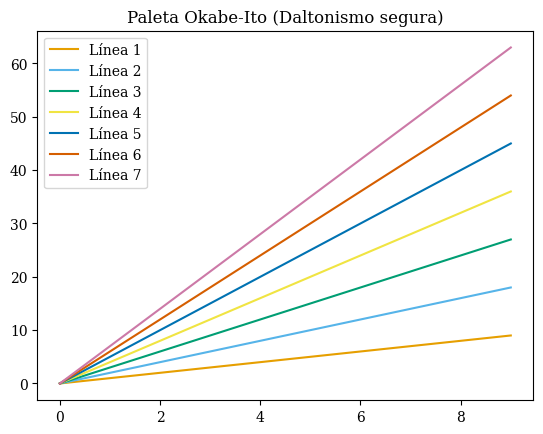

In [4]:
okabe_ito = [
    "#E69F00", # Orange
    "#56B4E9", # Sky Blue
    "#009E73", # Bluish Green
    "#F0E442", # Yellow
    "#0072B2", # Blue
    "#D55E00", # Vermilion
    "#CC79A7"  # Reddish Purple
]

plt.rcParams["axes.prop_cycle"] = plt.cycler(color=okabe_ito)

for i in range(7):
    plt.plot(range(10), [j*(i+1) for j in range(10)], label=f"Línea {i+1}")
plt.legend()
plt.title("Paleta Okabe-Ito (Daltonismo segura)")
plt.show()

## Gráfico de lineas publicaciones biblioteca por día.

Este código genera una gráfica de línea que muestra cómo van aumentando las publicaciones en tu biblioteca de Zotero a lo largo del tiempo.

Resumen de lo que se visualiza en la gráfica:

* Eje X (horizontal): las fechas (cada día en que se añadieron referencias a Zotero).
* Eje Y (vertical): la cantidad de publicaciones añadidas en esa fecha.
* Cada punto representa el número de ítems incorporados en un día específico.
* La línea une esos puntos, mostrando la tendencia temporal en la incorporación de referencias.
* Se incluyen marcadores y cuadrícula, lo que facilita identificar picos (días con muchas publicaciones) y periodos con baja o nula actividad.

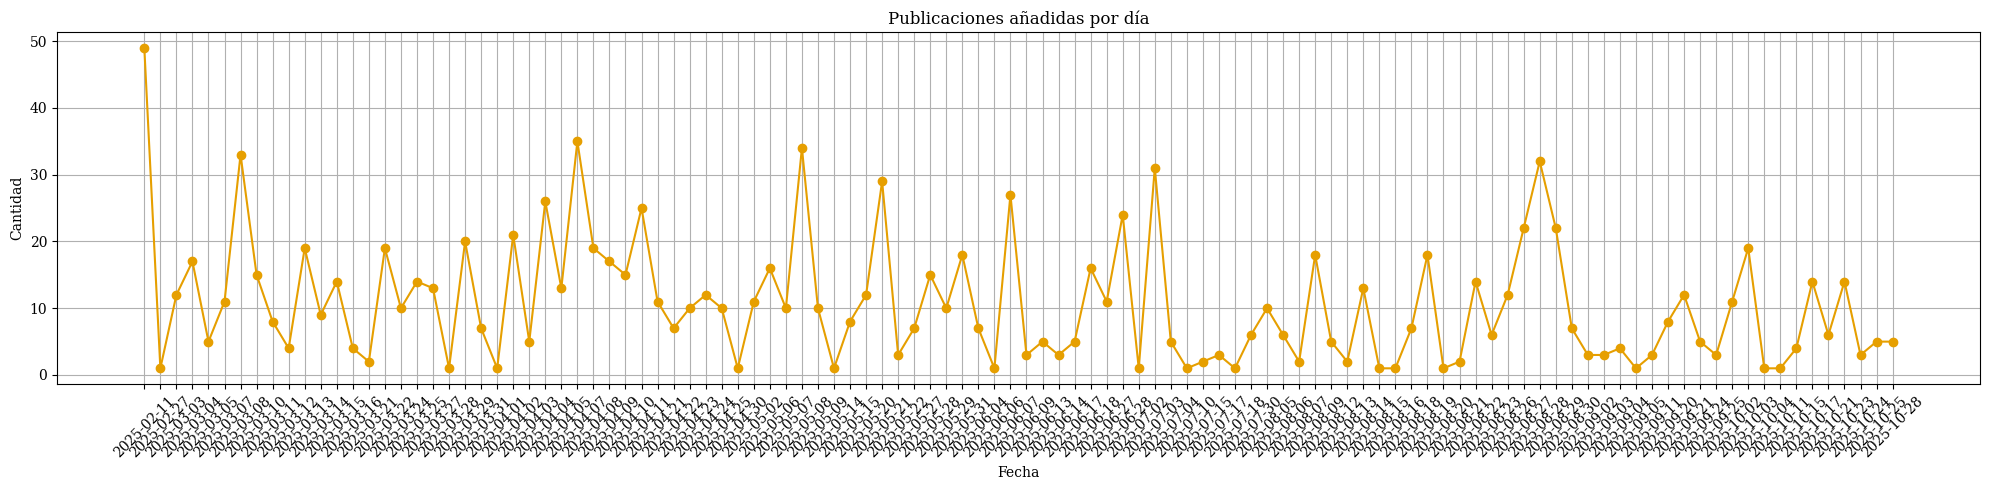

In [5]:
df = pd.DataFrame(items)
df["fecha"] = pd.to_datetime(df["fecha"])

# Agrupar por día
conteo_por_dia = df.groupby(df["fecha"].dt.date).size().reset_index(name="Total_Publicaciones")

# Opcional: convertir fechas a string para exportar
conteo_por_dia["fecha"] = conteo_por_dia["fecha"].astype(str)

# Generamos la grafica de publicaciones añadidas por día
plt.figure(figsize=(20, 5))
plt.plot(conteo_por_dia["fecha"], conteo_por_dia["Total_Publicaciones"], marker='o')
plt.xticks(rotation=45)
plt.title("Publicaciones añadidas por día")
plt.xlabel("Fecha")
plt.ylabel("Cantidad")
plt.tight_layout()
plt.grid(True)
plt.show()

Al agrupar las publicaciones por semana en lugar de por día, la gráfica se vuelve más limpia y comprensible. En la visualización diaria se generan muchos puntos dispersos, lo que puede hacer difícil identificar tendencias claras debido a la variabilidad natural (algunos días se agregan muchas referencias y otros ninguna).

En cambio, la vista semanal suaviza esas fluctuaciones y muestra con mayor claridad los periodos de mayor o menor productividad en la incorporación de referencias. Esto permite:

* Detectar picos semanales de trabajo en la recopilación bibliográfica.

* Observar de manera más estable la tendencia general en el tiempo.

* Comparar semanas entre sí para identificar patrones de actividad (por ejemplo, semanas intensivas de búsqueda vs. semanas más tranquilas).

La visualización por semana reduce el ruido del día a día y resalta las tendencias globales, facilitando el análisis de la evolución de tu biblioteca Zotero.

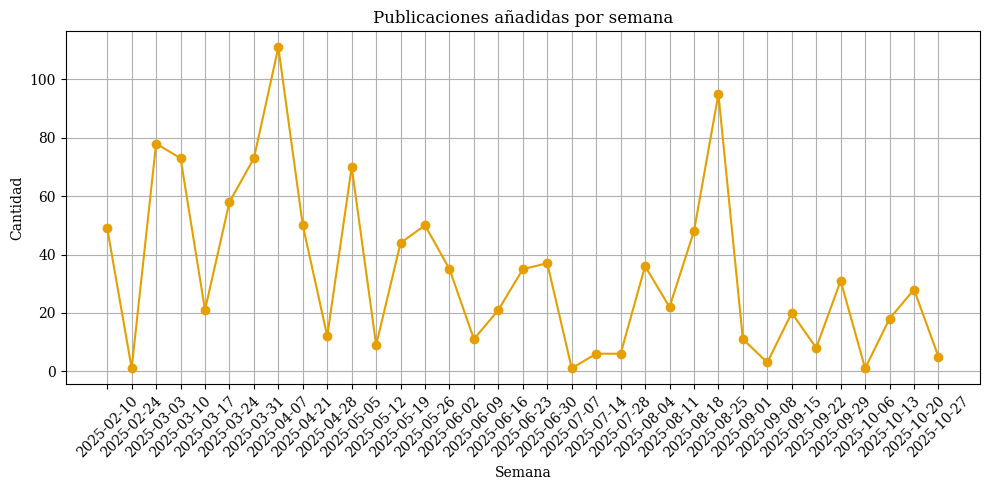

In [6]:
# Re-run the weekly graph cell to reflect the corrected 'fecha' data
# 🔹 Agrupar por semana
# Convertir la columna 'fecha' a datetime si aún no lo está
df["fecha"] = pd.to_datetime(df["fecha"])

# Eliminar la información de la zona horaria antes de convertir a período
df["fecha_sin_tz"] = df["fecha"].dt.tz_convert(None) if df["fecha"].dt.tz is not None else df["fecha"]

# Agrupar por semana (esto crea objetos tipo "2025-08-04/2025-08-10")
# Usamos dt.to_period('W').dt.start_time para obtener el inicio de la semana
df["semana"] = df["fecha_sin_tz"].dt.to_period("W").dt.start_time

# 🔹 Contar publicaciones por semana
conteo_semanal = df.groupby("semana").size().reset_index(name="Total_Publicaciones")

# 🔹 Convertir fechas para graficar o exportar
conteo_semanal["semana_str"] = conteo_semanal["semana"].dt.strftime("%Y-%m-%d")

# Vemos la grafica a nivel semanal
plt.figure(figsize=(10, 5))
plt.plot(conteo_semanal["semana_str"], conteo_semanal["Total_Publicaciones"], marker='o')
plt.xticks(rotation=45)
plt.title("Publicaciones añadidas por semana")
plt.xlabel("Semana")
plt.ylabel("Cantidad")
plt.grid(True)
plt.tight_layout()
plt.show()

# Gráfico de nube de palabras

La nube de palabras es una herramienta visual que permite identificar de manera rápida y clara los conceptos más relevantes dentro de un conjunto amplio de información. En este caso, la nube se construye a partir de las etiquetas asociadas a las publicaciones dentro de la biblioteca de Zotero, lo cual facilita el análisis temático de los recursos bibliográficos.

Su principal utilidad radica en que el tamaño de cada palabra refleja la frecuencia con la que aparece: las etiquetas más grandes representan temas recurrentes y de mayor peso dentro de la colección, mientras que las más pequeñas evidencian categorías específicas, secundarias o emergentes. Esto ofrece una visión global e intuitiva de las líneas de investigación predominantes, así como de la diversidad temática del repositorio.

Gracias a esta visualización es posible:

* Detectar áreas principales de estudio y los campos con mayor concentración de publicaciones.
* Observar patrones y tendencias temáticas sin necesidad de revisar documento por documento.
* Evaluar el equilibrio o sesgo del contenido bibliográfico (por ejemplo, exceso de textos en ciertos temas y ausencia en otros).
* Identificar oportunidades de mejora, permitiendo planear futuras adquisiciones con base en necesidades reales.

En resumen, la nube de palabras funciona como un mapa conceptual visual de la biblioteca, ofreciendo una interpretación rápida y comprensible del contenido académico disponible y fortaleciendo la toma de decisiones sobre gestión documental y desarrollo bibliográfico.

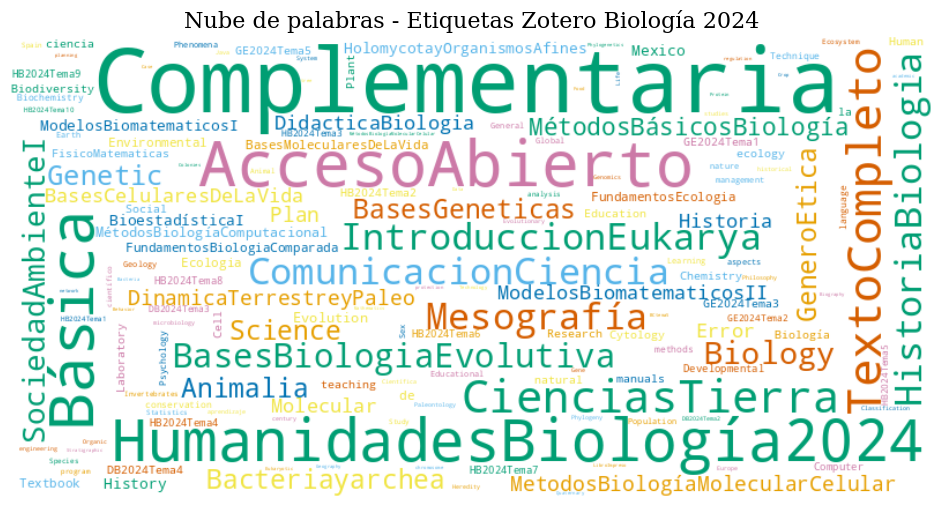

In [8]:
def color_func(word, font_size, position, orientation, random_state=None, **kwargs):
    return random.choice(okabe_ito)

# Extract all tags from the DataFrame and flatten the list
all_tags = [tag for sublist in df["etiquetas"].dropna() for tag in sublist]

# Convert all tags into a single string, separated by spaces
text = ' '.join(all_tags)

# Crear la nube
wordcloud = WordCloud(
    width=800,
    height=400,
    background_color='white',
    color_func=color_func,
    collocations=False
).generate(text)

# Mostrar la nube
plt.figure(figsize=(12, 6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title("Nube de palabras - Etiquetas Zotero Biología 2024", fontsize=16)
plt.show()

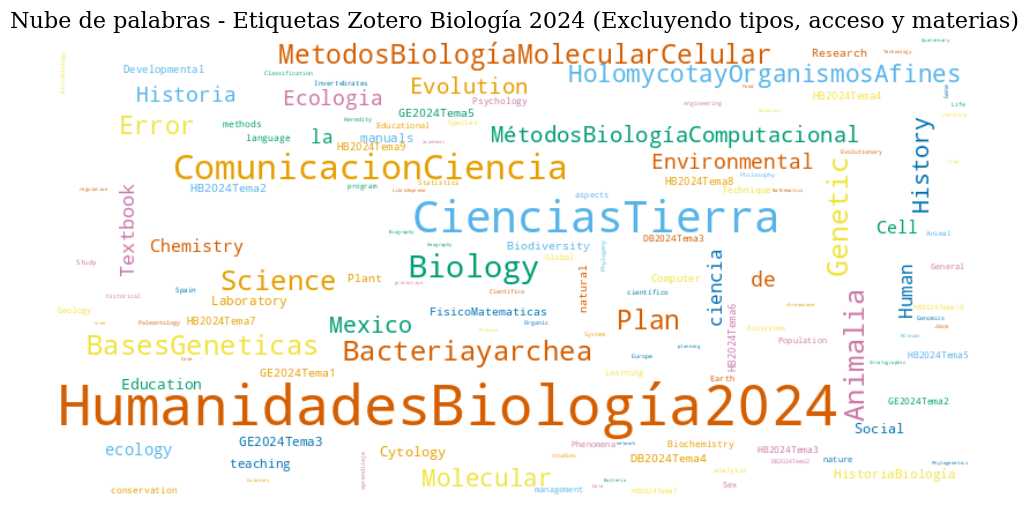

In [7]:
def color_func(word, font_size, position, orientation, random_state=None, **kwargs):
    return random.choice(okabe_ito)

# Extraer todas las etiquetas
all_tags = [tag for sublist in df["etiquetas"].dropna() for tag in sublist]

# Excluir
tags_to_exclude = [
    "AccesoAbierto", "TextoCompleto", "Básica", "Complementaria", "Mesografía",
    "BasesBiologiaEvolutiva", "BasesMolecularesDeLaVida", "FundamentosEcologia",
    "MétodosBásicosBiología", "GeneroEtica", "BasesCelularesDeLaVida",
    "FundamentosBiologiaComparada", "HistoriaBiologia", "IntroduccionEukarya",
    "ModelosBiomatematicosI", "ModelosBiomatematicosII", "BioestadísticaI",
    "DinamicaTerrestreyPaleo", "SociedadAmbienteI", "ComunicacionCienciaHumanidades",
    "Biología2024", "DidacticaBiologia", "MétodosBiologíaMolecularCelular"
]
# Se excluyen para un correcto análisis
tags_to_exclude_cleaned = ["".join([c for c in tag if c.isalnum() or c.isspace()]) for tag in tags_to_exclude]


# Limpiamos con un filtro las etiquetas
cleaned_filtered_tags = ["".join([c for c in tag if c.isalnum() or c.isspace()]) for tag in all_tags]
cleaned_filtered_tags = [tag for tag in cleaned_filtered_tags if tag not in tags_to_exclude_cleaned]

# Convertimos en una lista, esto separados por un espacio
text = ' '.join(cleaned_filtered_tags)

# Crear la nube
wordcloud = WordCloud(
    width=800,
    height=400,
    background_color='white',
    color_func=color_func,
    collocations=False
).generate(text)

# Mostrar la nube
plt.figure(figsize=(12, 6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title("Nube de palabras - Etiquetas Zotero Biología 2024 (Excluyendo tipos, acceso y materias)", fontsize=16)
plt.show()

Se realizo un análisis de los títulos de las referencias permitiendo garantizar la calidad y coherencia de la base bibliográfica. Dado que Zotero se usa frecuentemente para generar citas y bibliografías en documentos académicos, los errores en los títulos (como guiones mal colocados, uso incorrecto de mayúsculas, puntos innecesarios o faltas de ortografía) pueden trasladarse de forma automática a los artículos, tesis o reportes en los que se cite la fuente.

Este proceso de revisión y limpieza tiene varias ventajas:

* Coherencia formal: asegura que todos los títulos sigan el mismo estilo de escritura, evitando inconsistencias que afectan la presentación profesional del trabajo.

* Evitar errores en citas automáticas: al corregir la ortografía y el formato, se reducen fallos al exportar bibliografías en estilos como APA, MLA o Vancouver.

* Ahorro de tiempo: una biblioteca limpia significa menos correcciones manuales al final de un proyecto.

* Mayor credibilidad académica: las referencias son parte fundamental de cualquier investigación, y tener títulos bien escritos refleja rigurosidad y cuidado en el trabajo científico.

En síntesis, este análisis convierte la biblioteca de Zotero en una fuente depurada y confiable, lista para integrarse directamente en publicaciones sin arrastrar errores tipográficos o de estilo.

In [9]:
import pandas as pd
import re
from spellchecker import SpellChecker

# Diccionarios español e inglés
spell_es = SpellChecker(language='es')
spell_en = SpellChecker(language='en')

problemas = []

for titulo in df["titulo"].dropna():
    errores = []

    palabras = titulo.split()

    # 1. Regla APA: solo la primera palabra debe estar capitalizada (excepto nombres propios, aquí no los distinguimos)
    for i, word in enumerate(palabras):
        if i == 0:  # primera palabra
            continue
        elif word[0].isupper():  # palabra con mayúscula inicial que no debería
            errores.append("MAYÚSCULAS APA")
            break

    # 2. Punto final
    if titulo.strip().endswith("."):
        errores.append("PUNTO FINAL APA")

    # 3. Espacios dobles
    if "  " in titulo:
        errores.append("ESPACIOS DOBLES")

    # 4. Guiones
    if "-" in titulo:
        errores.append("GUIONES")

    # 5. Corchetes
    if "[" in titulo or "]" in titulo:
        errores.append("CORCHETES")

    # 6. Símbolos especiales
    if re.search(r"[@#\$%\^&\*\~\=]", titulo):
        errores.append("SÍMBOLOS ESPECIALES")

    # 7. Ortografía (es/en)
    palabras_limpias = re.findall(r'\b\w+\b', titulo.lower())
    errores_ort = []
    for p in palabras_limpias:
        if p not in spell_es and p not in spell_en:
            errores_ort.append(p)

    if len(errores_ort) >= 2:
        errores.append("ORTOGRAFÍA")

    # Guardar si hay errores
    if errores:
        problemas.append({"titulo": titulo, "errores": ", ".join(errores)})

df_errores = pd.DataFrame(problemas)
print(f"🔎 Títulos problemáticos encontrados (APA): {len(df_errores)}")
df_errores.head(10)



🔎 Títulos problemáticos encontrados (APA): 553


,titulo,errores
0,"Slayers, Saviors, Servants and Sex: An Exposé ...",MAYÚSCULAS APA
1,"Growth, Differentiation and Sexuality",MAYÚSCULAS APA
2,Genetics and Biotechnology,MAYÚSCULAS APA
3,Sex in Fungi: Molecular Determination and Evol...,MAYÚSCULAS APA
4,Fungal Genomics,MAYÚSCULAS APA
5,Biocommunication of Fungi,MAYÚSCULAS APA
6,Molecular Biology of Fungal Development,MAYÚSCULAS APA
7,Fungal Morphogenesis,MAYÚSCULAS APA
8,Biology of the Fungal Cell,MAYÚSCULAS APA
9,"Growth, Differentiation and Sexuality",MAYÚSCULAS APA


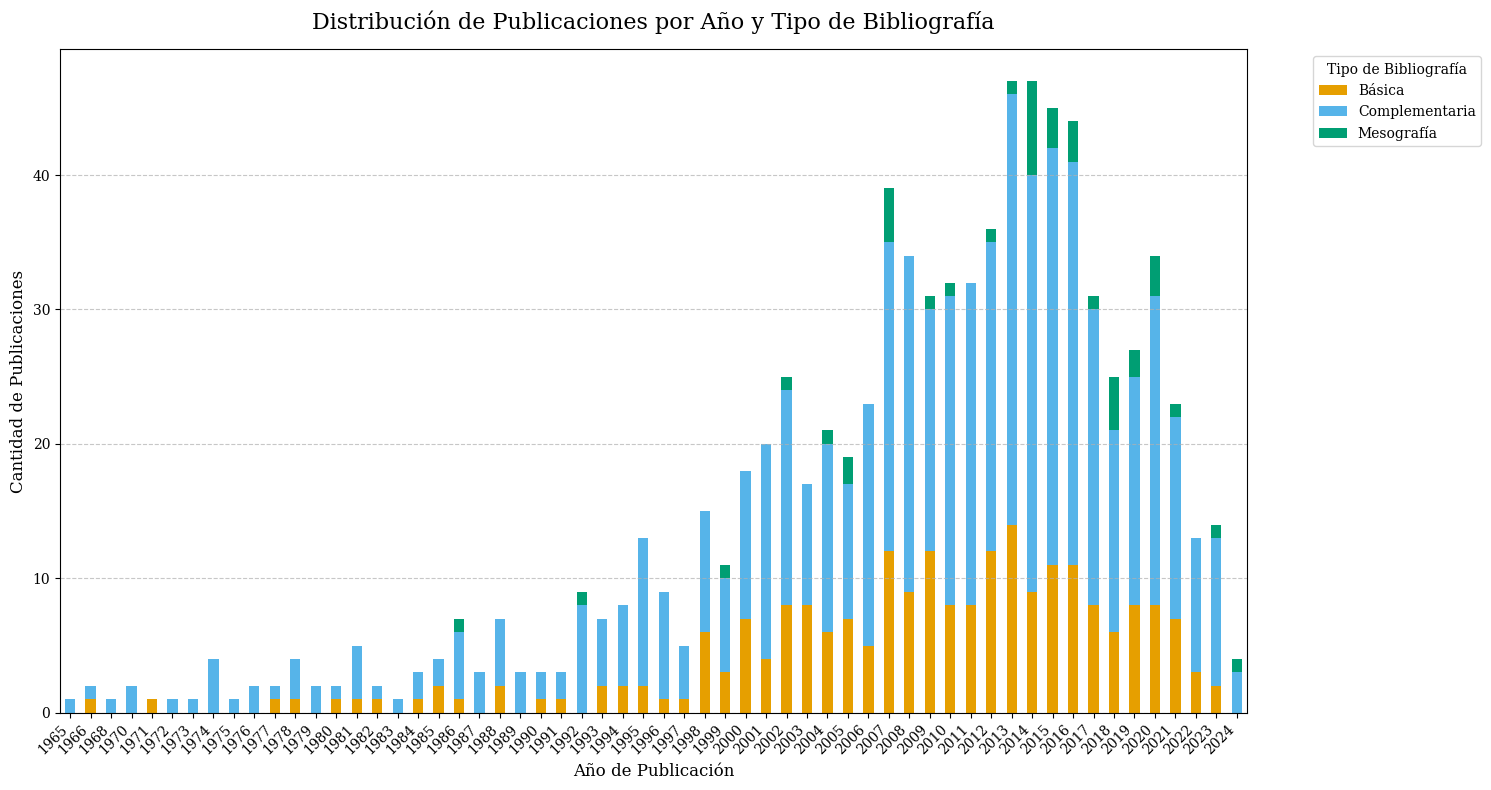

In [10]:
import re
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

def extraer_anio(fecha_texto):
    if not isinstance(fecha_texto, str):
        return np.nan
    match = re.search(r"\b(19|20)\d{2}\b", fecha_texto)
    return int(match.group()) if match else np.nan

df["año"] = df["fecha_publicacion"].apply(extraer_anio)

# Convertir la columna 'etiquetas' a una lista si no lo es
df['etiquetas'] = df['etiquetas'].apply(lambda x: x if isinstance(x, list) else [])

# Expandir las etiquetas para tener una fila por cada etiqueta de cada ítem
df_expanded = df.explode('etiquetas')

# Limpiar las etiquetas de posibles emojis o caracteres especiales
df_expanded['etiquetas_limpias'] = df_expanded['etiquetas'].apply(lambda x: "".join([c for c in str(x) if c.isalnum() or c.isspace()]))

# Definir los tipos de bibliografía de interés
tipos_bibliografia = ["Básica", "Complementaria", "Mesografía"]

# Filtrar solo las filas que corresponden a los tipos de bibliografía definidos
df_tipos = df_expanded[df_expanded['etiquetas_limpias'].isin(tipos_bibliografia)].copy()

# Agrupar por año y por tipo de bibliografía, y contar
conteo_por_anio_tipo = df_tipos.groupby(["año", "etiquetas_limpias"]).size().unstack(fill_value=0)

# Eliminar filas con año nulo si existen
conteo_por_anio_tipo = conteo_por_anio_tipo[conteo_por_anio_tipo.index.notnull()]

# Asegurarse de que los años sean enteros para el eje x
conteo_por_anio_tipo.index = conteo_por_anio_tipo.index.astype(int)

# Ordenar por año
conteo_por_anio_tipo = conteo_por_anio_tipo.sort_index()

# Paleta Okabe-Ito (segura para daltónicos)
okabe_ito = [
    "#E69F00",  # Orange
    "#56B4E9",  # Sky Blue
    "#009E73",  # Bluish Green
    "#F0E442",  # Yellow
    "#0072B2",  # Blue
    "#D55E00",  # Vermilion
    "#CC79A7",  # Reddish Purple
    "#999999"   # Grey (if needed for more categories)
]

# Crear el gráfico de barras apiladas
plt.figure(figsize=(15, 8)) # Aumentar tamaño
conteo_por_anio_tipo[tipos_bibliografia].plot(kind='bar', stacked=True, figsize=(15, 8), color=okabe_ito[:len(tipos_bibliografia)], ax=plt.gca()) # Usar solo los colores necesarios de la paleta


plt.title("Distribución de Publicaciones por Año y Tipo de Bibliografía", fontsize=16, pad=15)
plt.xlabel("Año de Publicación", fontsize=12)
plt.ylabel("Cantidad de Publicaciones", fontsize=12)
plt.legend(title="Tipo de Bibliografía", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(axis="y", linestyle="--", alpha=0.7)
plt.xticks(rotation=45, ha='right') # Rotar etiquetas del eje X para mejor legibilidad
plt.tight_layout()
plt.show()

                                              titulo fecha_publicacion     año
0                          Essential fungal genetics              2002  2002.0
1  Slayers, Saviors, Servants and Sex: An Exposé ...              2001  2001.0
2              Growth, Differentiation and Sexuality              2016  2016.0
3                         Genetics and Biotechnology              2004  2004.0
4  Sex in Fungi: Molecular Determination and Evol...        2007-08-27  2007.0


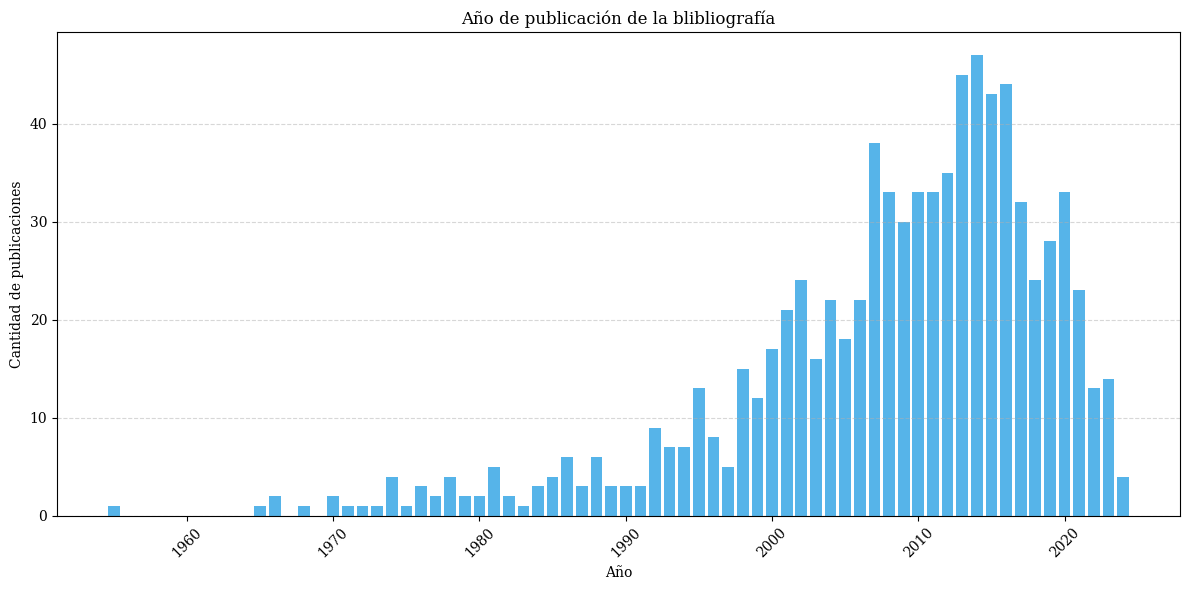

In [11]:
import re
import numpy as np

def extraer_anio(fecha_texto):
    if not isinstance(fecha_texto, str):
        return np.nan
    match = re.search(r"\b(19|20)\d{2}\b", fecha_texto)
    return int(match.group()) if match else np.nan

df["año"] = df["fecha_publicacion"].apply(extraer_anio)

print(df[["titulo", "fecha_publicacion", "año"]].head())

conteo_por_anio = df["año"].value_counts().sort_index().reset_index()
conteo_por_anio.columns = ["Año", "Cantidad"]
conteo_por_anio = conteo_por_anio[conteo_por_anio["Año"].notnull()]  # Filtrar nulos
conteo_por_anio["Año"] = conteo_por_anio["Año"].astype(int)
conteo_por_anio

import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))
plt.bar(conteo_por_anio["Año"], conteo_por_anio["Cantidad"], color="#56B4E9")
plt.title("Año de publicación de la blibliografía")
plt.xlabel("Año")
plt.ylabel("Cantidad de publicaciones")
plt.grid(axis="y", linestyle="--", alpha=0.5)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

                                              titulo fecha_publicacion     año
0                          Essential fungal genetics              2002  2002.0
1  Slayers, Saviors, Servants and Sex: An Exposé ...              2001  2001.0
2              Growth, Differentiation and Sexuality              2016  2016.0
3                         Genetics and Biotechnology              2004  2004.0
4  Sex in Fungi: Molecular Determination and Evol...        2007-08-27  2007.0


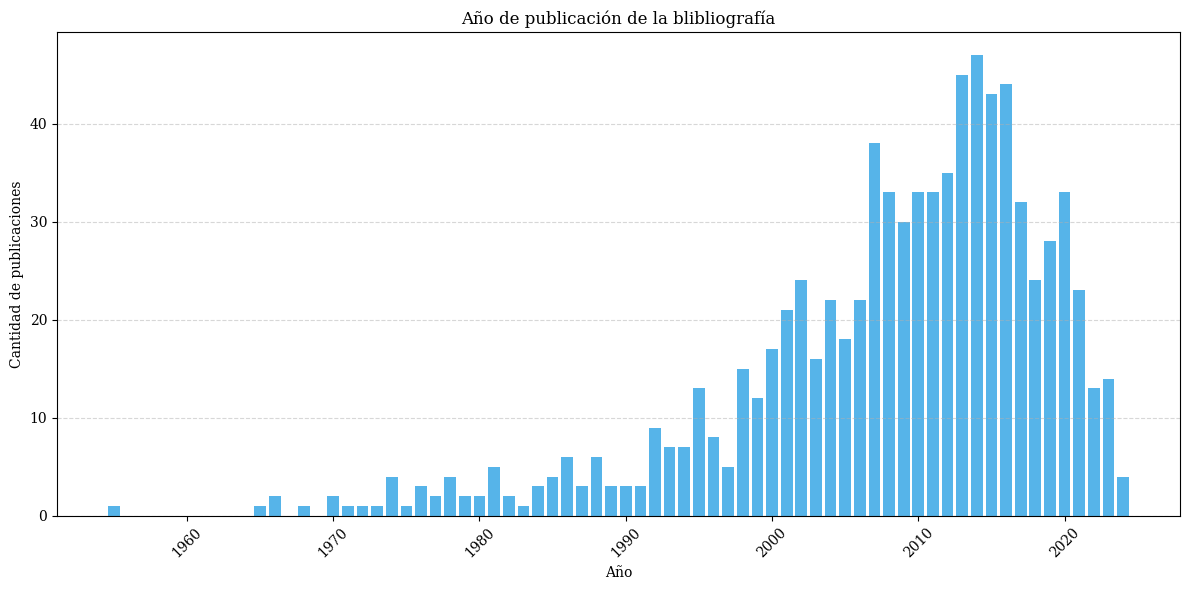

In [12]:
import re
import numpy as np

def extraer_anio(fecha_texto):
    if not isinstance(fecha_texto, str):
        return np.nan
    match = re.search(r"\b(19|20)\d{2}\b", fecha_texto)
    return int(match.group()) if match else np.nan

df["año"] = df["fecha_publicacion"].apply(extraer_anio)

print(df[["titulo", "fecha_publicacion", "año"]].head())

conteo_por_anio = df["año"].value_counts().sort_index().reset_index()
conteo_por_anio.columns = ["Año", "Cantidad"]
conteo_por_anio = conteo_por_anio[conteo_por_anio["Año"].notnull()]  # Filtrar nulos
conteo_por_anio["Año"] = conteo_por_anio["Año"].astype(int)
conteo_por_anio

import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))
plt.bar(conteo_por_anio["Año"], conteo_por_anio["Cantidad"], color="#56B4E9")
plt.title("Año de publicación de la blibliografía")
plt.xlabel("Año")
plt.ylabel("Cantidad de publicaciones")
plt.grid(axis="y", linestyle="--", alpha=0.5)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

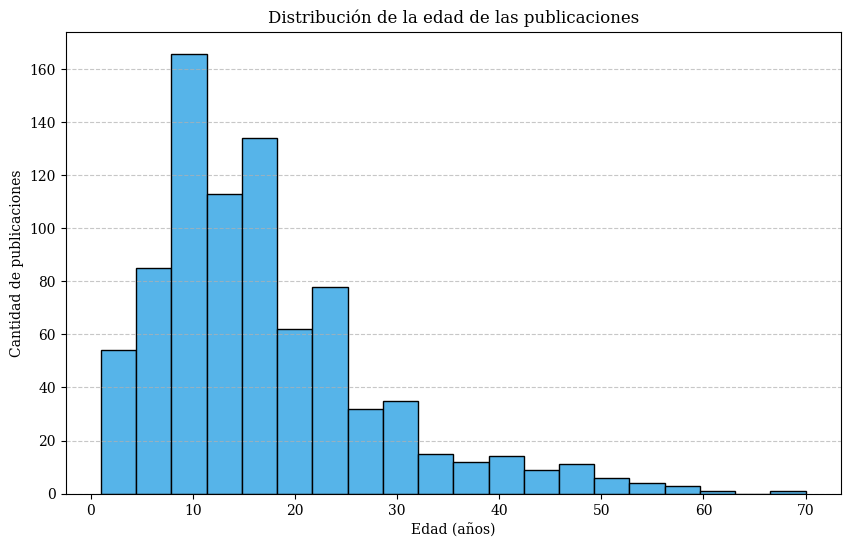

In [13]:
from datetime import datetime

anio_actual = datetime.now().year

# Filtramos filas con año válido y creamos una copia explícita
df_validos = df[df["año"].notnull()].copy()

# Calculamos edad de cada publicación
df_validos["edad"] = anio_actual - df_validos["año"]

# Vemos los primeros (opcional, para depuración)
# display(df_validos.head())

import matplotlib.pyplot as plt

plt.figure(figsize=(10,6))
plt.hist(df_validos["edad"], bins=20, color="#56B4E9", edgecolor="black")
plt.title("Distribución de la edad de las publicaciones")
plt.xlabel("Edad (años)")
plt.ylabel("Cantidad de publicaciones")
plt.grid(axis="y", linestyle="--", alpha=0.7)
plt.show()

In [14]:
# Edad promedio de la libreria.
edad_promedio = df_validos["edad"].mean()
print(f"La edad promedio de las publicaciones es de {edad_promedio:.2f} años.")

La edad promedio de las publicaciones es de 16.99 años.


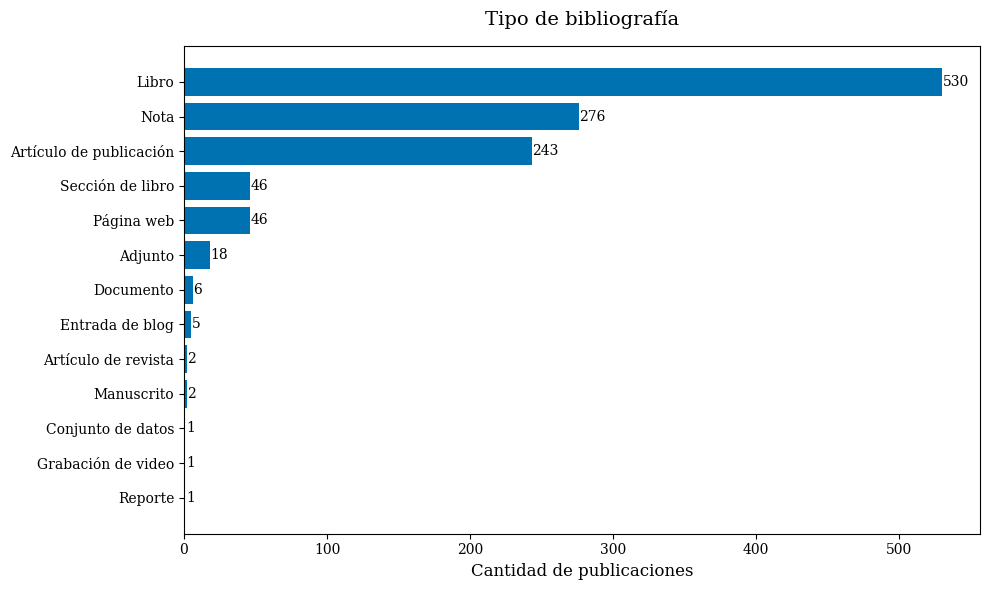

In [15]:
# ============================
# 📊 Gráfica de barras: Tipos de ítems Zotero
# ============================

if "tipo" in df.columns:
    # Contar los tipos de ítem
    conteo_tipos = df["tipo"].value_counts().sort_values()

    # Mapear nombres de tipos a español con espacios y mayúscula inicial
    mapeo_tipos_espanol = {
        'report': 'Reporte',
        'videoRecording': 'Grabación de video',
        'dataset': 'Conjunto de datos',
        'manuscript': 'Manuscrito',
        'magazineArticle': 'Artículo de revista',
        'blogPost': 'Entrada de blog',
        'document': 'Documento',
        'attachment': 'Adjunto',
        'webpage': 'Página web',
        'bookSection': 'Sección de libro',
        'journalArticle': 'Artículo de publicación',
        'note': 'Nota',
        'book': 'Libro'
    }

    # Aplicar el mapeo al índice del conteo
    conteo_tipos.index = conteo_tipos.index.map(mapeo_tipos_espanol)


    # Paleta accesible (Okabe-Ito) - Azul es el quinto color
    okabe_ito = [
        "#E69F00", "#56B4E9", "#009E73", "#F0E442", "#0072B2", "#D55E00", "#CC79A7"
    ]
    color_azul = okabe_ito[4] # Índice 4 es el color azul "#0072B2"


    # Crear la gráfica
    plt.figure(figsize=(10, 6))
    bars = plt.barh(
        conteo_tipos.index,
        conteo_tipos.values,
        color=color_azul # Usar solo el color azul
    )

    # Etiquetas y estilo
    plt.title("Tipo de bibliografía", fontsize=14, pad=15)
    plt.xlabel("Cantidad de publicaciones", fontsize=12)
    plt.ylabel("", fontsize=12)

    # Añadir etiquetas de valor al final de cada barra
    for bar in bars:
        plt.text(
            bar.get_width() + 0.3,                 # posición x
            bar.get_y() + bar.get_height() / 2,    # posición y
            str(int(bar.get_width())),              # texto (conteo)
            va="center", ha="left", fontsize=10
        )

    plt.tight_layout()
    plt.show()

else:
    print("⚠️ No se encontró la columna 'tipo'. Asegúrate de incluir item_data.get('itemType') en el diccionario.")

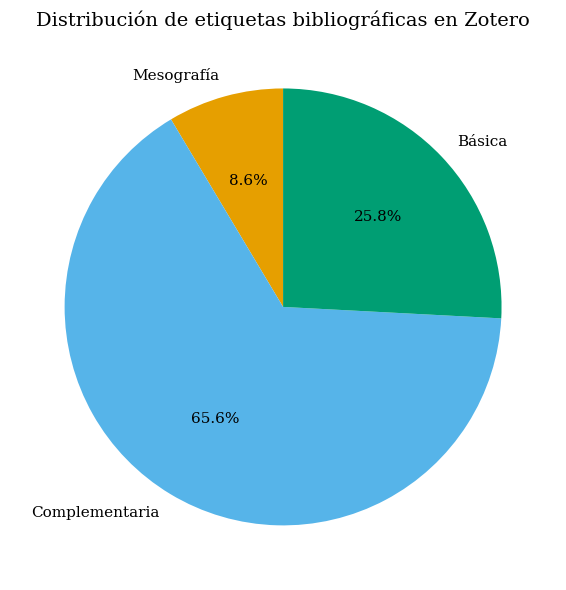

In [16]:
# ============================
# 🥧 Gráfica de pastel: etiquetas de tipo bibliografía
# ============================

import pandas as pd
import matplotlib.pyplot as plt

# Paleta Okabe-Ito (segura para daltónicos)
okabe_ito = [
    "#E69F00",  # Orange
    "#56B4E9",  # Sky Blue
    "#009E73",  # Bluish Green
    "#F0E442",  # Yellow
    "#0072B2",  # Blue
    "#D55E00",  # Vermilion
    "#CC79A7"   # Reddish Purple
]

# Etiquetas a analizar (sin emojis para evitar problemas de visualización)
etiquetas_objetivo = ["Mesografía", "Complementaria", "Básica"]

# Contar cuántas veces aparece cada una
conteo_etiquetas = {et: 0 for et in etiquetas_objetivo}

for etiquetas in df["etiquetas"]:
    if isinstance(etiquetas, list):
        for e in etiquetas:
            # Limpiar la etiqueta de emojis antes de comparar
            cleaned_e = "".join([c for c in e if c.isalnum() or c.isspace()])
            if cleaned_e in conteo_etiquetas:
                conteo_etiquetas[cleaned_e] += 1
    elif isinstance(etiquetas, str):
        # Limpiar la etiqueta de emojis antes de comparar
        cleaned_etiquetas = "".join([c for c in etiquetas if c.isalnum() or c.isspace()])
        for et in etiquetas_objetivo:
            if et in cleaned_etiquetas:
                conteo_etiquetas[et] += 1


# Crear gráfica
plt.figure(figsize=(6, 6))
plt.pie(
    conteo_etiquetas.values(),
    labels=conteo_etiquetas.keys(),
    autopct="%1.1f%%",
    startangle=90,
    colors=okabe_ito[:len(conteo_etiquetas)],
    textprops={"fontsize": 11}
)
plt.title("Distribución de etiquetas bibliográficas en Zotero", fontsize=14)
plt.tight_layout()
plt.show()

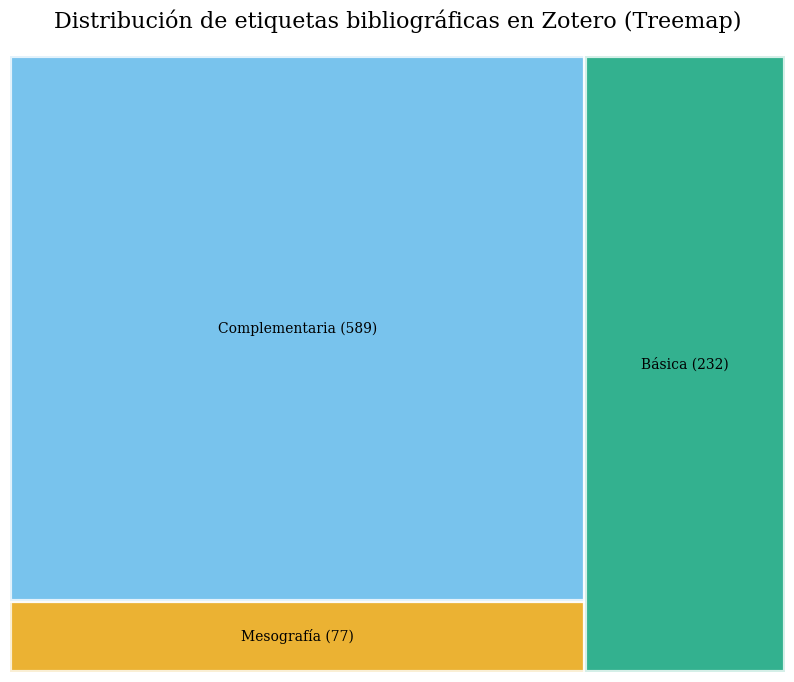

In [17]:
import matplotlib.pyplot as plt
import squarify # Importar squarify
import pandas as pd

# Paleta Okabe-Ito (segura para daltónicos)
okabe_ito = [
    "#E69F00",  # Orange
    "#56B4E9",  # Sky Blue
    "#009E73",  # Bluish Green
    "#F0E442",  # Yellow
    "#0072B2",  # Blue
    "#D55E00",  # Vermilion
    "#CC79A7"   # Reddish Purple
]

# Los datos ya están en `conteo_etiquetas` de la celda `oeR_q-AVqAtj`
# Convertir el diccionario a listas para squarify
sizes = list(conteo_etiquetas.values())
labels = [f'{k} ({v})' for k, v in conteo_etiquetas.items()]

plt.figure(figsize=(10, 8))
squarify.plot(
    sizes=sizes,
    label=labels,
    color=okabe_ito[:len(sizes)], # Usar la paleta Okabe-Ito
    alpha=0.8,
    bar_kwargs={'linewidth': 3, 'edgecolor': 'white'} # Espacio entre los rectángulos
)

plt.title("Distribución de etiquetas bibliográficas en Zotero (Treemap)", fontsize=16, pad=20)
plt.axis('off') # Ocultar ejes
plt.show()

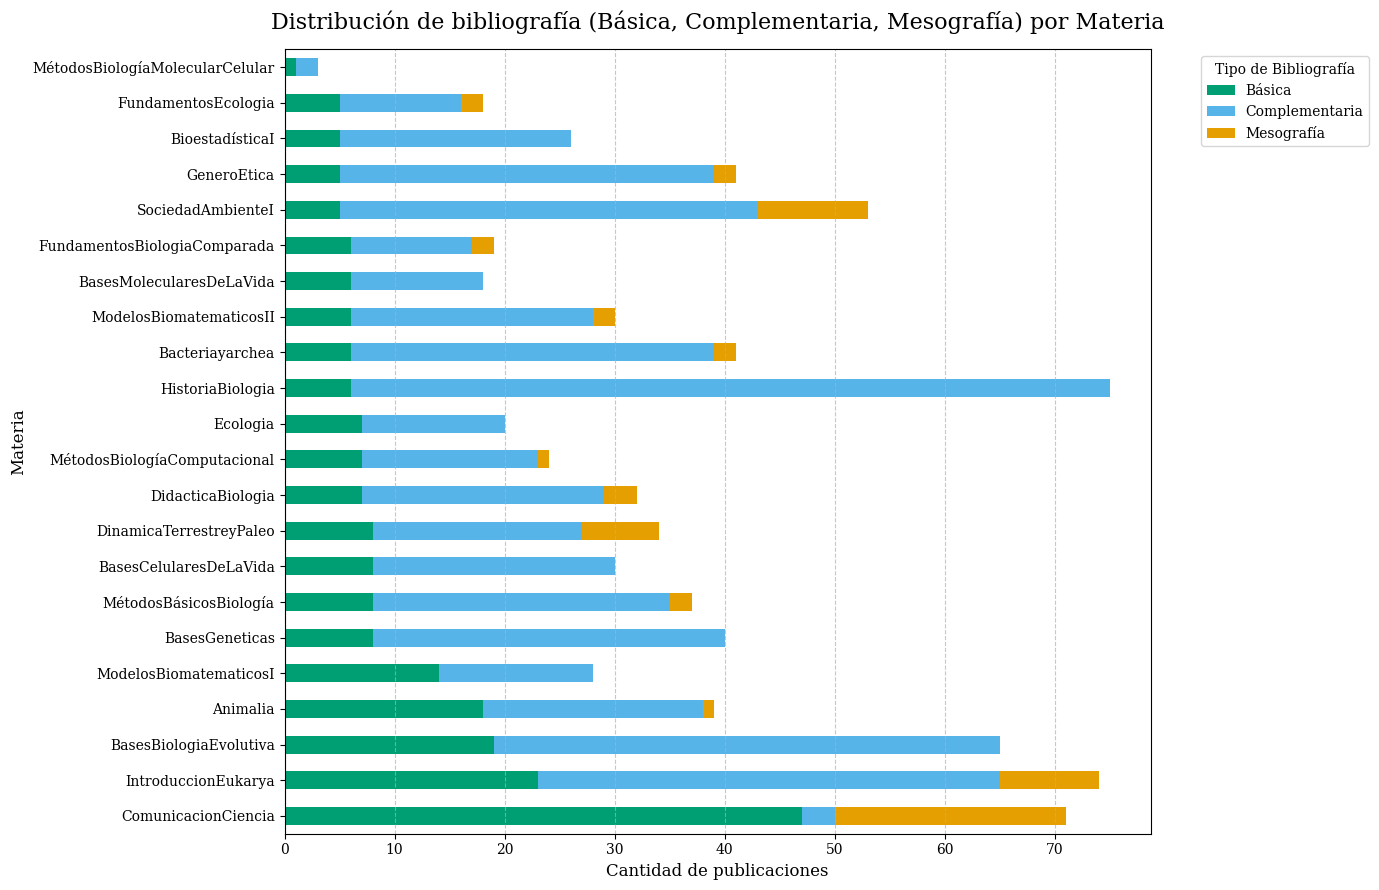

In [18]:
# Lista de etiquetas de interés proporcionada por el usuario (materias)
etiquetas_materias = [
    "Bacteriayarchea",
    "BasesBiologiaEvolutiva",
    "BasesMolecularesDeLaVida",
    "FundamentosEcologia",
    "MétodosBásicosBiología",
    "GeneroEtica",
    "BasesCelularesDeLaVida",
    "FundamentosBiologiaComparada",
    "HistoriaBiologia",
    "IntroduccionEukarya",
    "ModelosBiomatematicosI",
    "BasesGeneticas",
    "MétodosBiologíaComputacional",
    "ModelosBiomatematicosII",
    "BioestadísticaI",
    "DinamicaTerrestreyPaleo",
    "Ecologia",
    "SociedadAmbienteI",
    "ComunicacionCiencia",
    "DidacticaBiologia",
    "MétodosBiologíaMolecularCelular",
    "Animalia"
]

# Tipos de bibliografía a incluir en el apilado
tipos_bibliografia = ["Básica", "Complementaria", "Mesografía"]

# Crear un diccionario para almacenar los conteos
conteo_apilado = {materia: {tipo: 0 for tipo in tipos_bibliografia} for materia in etiquetas_materias}

# Recorrer el DataFrame para contar
for index, row in df.iterrows():
    etiquetas_item = row["etiquetas"]
    if isinstance(etiquetas_item, list):
        # Limpiar y procesar etiquetas del ítem
        cleaned_etiquetas_item = ["".join([c for c in e if c.isalnum() or c.isspace()]) for e in etiquetas_item]

        # Identificar la materia (o materias) a la que pertenece el ítem
        materias_encontradas = [et for et in cleaned_etiquetas_item if et in etiquetas_materias]

        # Identificar el tipo de bibliografía
        tipo_encontrado = None
        for tipo in tipos_bibliografia:
            if tipo in cleaned_etiquetas_item:
                tipo_encontrado = tipo
                break # Asumimos que un ítem solo tiene un tipo (Básica, Complementaria, Mesografía)

        # Si se encontró una materia y un tipo, incrementar el contador
        if materias_encontradas and tipo_encontrado:
            for materia in materias_encontradas:
                 conteo_apilado[materia][tipo_encontrado] += 1

# Convertir el diccionario a un DataFrame para graficar
# Orientamos el DataFrame para que las filas sean materias y las columnas tipos de bibliografía
df_conteo_apilado = pd.DataFrame(conteo_apilado).T
df_conteo_apilado = df_conteo_apilado.sort_values(by=tipos_bibliografia, ascending=False) # Ordenar por el total o por un tipo específico si se prefiere

# Crear el gráfico de barras apiladas
plt.figure(figsize=(14, 9)) # Aumentar tamaño para mejor visualización

# Paleta Okabe-Ito (segura para daltónicos)
okabe_ito = [
    "#E69F00",  # Orange
    "#56B4E9",  # Sky Blue
    "#009E73",  # Bluish Green
    "#F0E442",  # Yellow
    "#0072B2",  # Blue
    "#D55E00",  # Vermilion
    "#CC79A7"   # Reddish Purple
]

# Asignar colores según el orden del pie chart (celda oeR_q-AVqAtj)
# En el pie chart, el orden es Mesografía, Complementaria, Básica
# Los colores en ese orden son Naranja (#E69F00), Azul cielo (#56B4E9), Verde azulado (#009E73)
colores_apilado_dict = {
    "Mesografía": okabe_ito[0],      # Naranja
    "Complementaria": okabe_ito[1], # Azul cielo
    "Básica": okabe_ito[2]         # Verde azulado
}

# Aseguramos que el orden de los colores en la lista coincida con el orden de las columnas del DataFrame
# El DataFrame df_conteo_apilado tiene las columnas en el orden ["Básica", "Complementaria", "Mesografía"]
colores_grafica_apilada = [colores_apilado_dict[col] for col in df_conteo_apilado[tipos_bibliografia].columns]


df_conteo_apilado[tipos_bibliografia].plot(kind='barh', stacked=True, color=colores_grafica_apilada, ax=plt.gca())


plt.title("Distribución de bibliografía (Básica, Complementaria, Mesografía) por Materia", fontsize=16, pad=15)
plt.xlabel("Cantidad de publicaciones", fontsize=12)
plt.ylabel("Materia", fontsize=12)
plt.legend(title="Tipo de Bibliografía", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(axis="x", linestyle="--", alpha=0.7)
plt.tight_layout()
plt.show()

In [19]:
# Mostrar la tabla con los conteos por materia y tipo de bibliografía
print("\nConteo de Bibliografía por Materia y Tipo:")
display(df_conteo_apilado)


Conteo de Bibliografía por Materia y Tipo:


,Básica,Complementaria,Mesografía
ComunicacionCiencia,47,3,21
IntroduccionEukarya,23,42,9
BasesBiologiaEvolutiva,19,46,0
Animalia,18,20,1
ModelosBiomatematicosI,14,14,0
BasesGeneticas,8,32,0
MétodosBásicosBiología,8,27,2
BasesCelularesDeLaVida,8,22,0
DinamicaTerrestreyPaleo,8,19,7
DidacticaBiologia,7,22,3


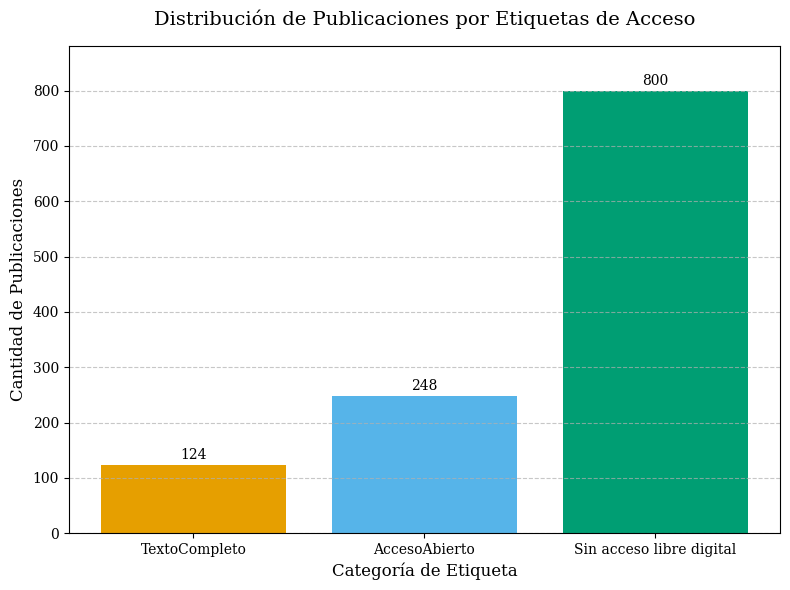

In [20]:
# Definir las etiquetas de interés (limpiando posibles emojis o caracteres especiales)
etiqueta_texto_completo = "TextoCompleto" # Asumiendo que limpiamos el emoji 🔺
etiqueta_acceso_abierto = "AccesoAbierto" # Asumiendo que limpiamos el emoji 🆓

# Inicializar contadores
conteo_categorias = {
    etiqueta_texto_completo: 0,
    etiqueta_acceso_abierto: 0,
    "Sin acceso libre digital": 0
}

# Recorrer el DataFrame para contar las publicaciones por categoría
for index, row in df.iterrows():
    etiquetas_item = row["etiquetas"]
    has_texto_completo = False
    has_acceso_abierto = False

    if isinstance(etiquetas_item, list):
        cleaned_etiquetas = ["".join([c for c in e if c.isalnum() or c.isspace()]) for e in etiquetas_item]

        if etiqueta_texto_completo in cleaned_etiquetas:
            has_texto_completo = True
        if etiqueta_acceso_abierto in cleaned_etiquetas:
            has_acceso_abierto = True

    # Categorizar el ítem
    if has_texto_completo and not has_acceso_abierto:
        conteo_categorias[etiqueta_texto_completo] += 1
    elif not has_texto_completo and has_acceso_abierto:
        conteo_categorias[etiqueta_acceso_abierto] += 1
    elif not has_texto_completo and not has_acceso_abierto:
        conteo_categorias["Sin acceso libre digital"] += 1

# Convertir el diccionario a un DataFrame para graficar
df_conteo_categorias = pd.DataFrame(list(conteo_categorias.items()), columns=["Categoría", "Cantidad"])

# Crear el gráfico (por ejemplo, un gráfico de barras o de pastel)
plt.figure(figsize=(8, 6))
# Usaremos un gráfico de barras para este caso
bars = plt.bar(
    df_conteo_categorias["Categoría"],
    df_conteo_categorias["Cantidad"],
    color=[okabe_ito[0], okabe_ito[1], okabe_ito[2]] # Usamos los primeros colores de la paleta Okabe-Ito
)

# Añadir etiquetas de valor encima de cada barra
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval + 5, int(yval), ha='center', va='bottom') # Adjust +5 for spacing


plt.title("Distribución de Publicaciones por Etiquetas de Acceso", fontsize=14, pad=15)
plt.xlabel("Categoría de Etiqueta", fontsize=12)
plt.ylabel("Cantidad de Publicaciones", fontsize=12)
plt.ylim(0, df_conteo_categorias["Cantidad"].max() * 1.1) # Ajustar límite Y para espacio de etiquetas
plt.grid(axis="y", linestyle="--", alpha=0.7)
plt.tight_layout()
plt.show()

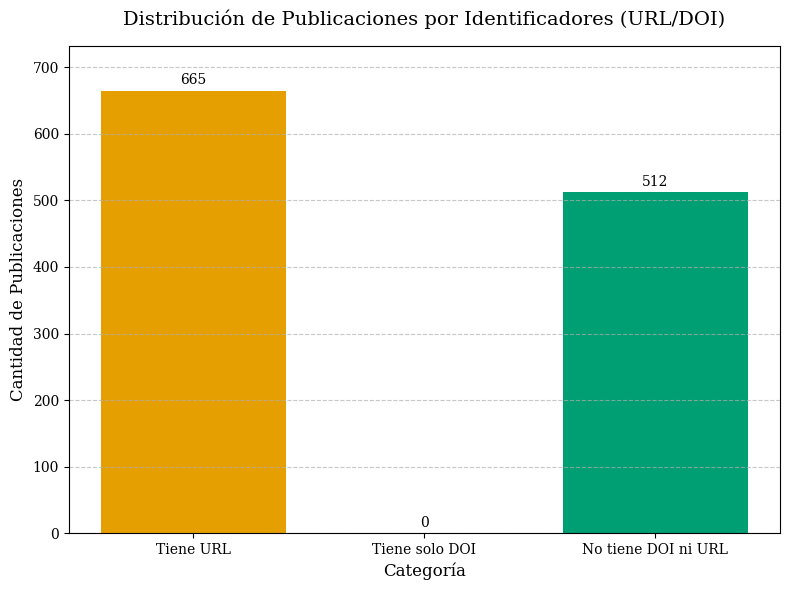

In [21]:
# Inicializar contadores para las nuevas categorías
conteo_identificadores = {
    "Tiene URL": 0,         # Tiene URL (con o sin DOI)
    "Tiene solo DOI": 0,    # Tiene DOI pero no URL
    "No tiene DOI ni URL": 0
}

# Recorrer el DataFrame para categorizar y contar
for index, row in df.iterrows():
    has_doi = False
    has_url = False

    # Verificar si tiene DOI (comúnmente en el campo 'extra')
    extra_field = row.get("extra")
    if isinstance(extra_field, str) and "doi:" in extra_field.lower():
        has_doi = True

    # Verificar si tiene URL
    # Correcting the URL check: ensure the column exists and is not empty/NaN
    url_field = row.get("url")
    if pd.notna(url_field) and isinstance(url_field, str) and url_field.strip() != "":
        has_url = True


    # Categorizar el ítem (nueva lógica)
    if has_url:
        conteo_identificadores["Tiene URL"] += 1
    elif has_doi and not has_url: # Check for DOI only if no URL is found
        conteo_identificadores["Tiene solo DOI"] += 1
    elif not has_doi and not has_url:
        conteo_identificadores["No tiene DOI ni URL"] += 1


# Convertir el diccionario a un DataFrame para graficar
df_conteo_identificadores = pd.DataFrame(list(conteo_identificadores.items()), columns=["Categoría", "Cantidad"])

# Crear el gráfico (por ejemplo, un gráfico de barras)
plt.figure(figsize=(8, 6))
bars = plt.bar(
    df_conteo_identificadores["Categoría"],
    df_conteo_identificadores["Cantidad"],
    color=[okabe_ito[0], okabe_ito[1], okabe_ito[2]] # Usamos los primeros colores de la paleta Okabe-Ito
)

# Añadir etiquetas de valor encima de cada barra
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval + 5, int(yval), ha='center', va='bottom') # Adjust +5 for spacing


plt.title("Distribución de Publicaciones por Identificadores (URL/DOI)", fontsize=14, pad=15)
plt.xlabel("Categoría", fontsize=12)
plt.ylabel("Cantidad de Publicaciones", fontsize=12)
plt.ylim(0, df_conteo_identificadores["Cantidad"].max() * 1.1) # Ajustar límite Y para espacio de etiquetas
plt.grid(axis="y", linestyle="--", alpha=0.7)
plt.tight_layout()
plt.show()

In [22]:
import re
# Crear el diccionario base
conteo_identificadores = {
    "Tiene URL": 0,
    "Tiene DOI": 0,
    "Tiene ISBN": 0,
    "Tiene OCLC": 0,
    "No presenta identificador": 0
}

# Recorrer el DataFrame
for _, row in df.iterrows():
    extra_field = row.get("extra", "")
    doi_field = row.get("DOI", "")
    isbn_field = row.get("ISBN", "")
    url_field = row.get("url", "")

    # Verificar DOI (insensible a mayúsculas)
    has_doi = bool(doi_field)#bool(re.search(r"doi:\s*\S+", str(extra_field), re.IGNORECASE))


    has_oclc = bool(re.search(r"oclc:\s*\S+", str(extra_field), re.IGNORECASE))

    # Verificar ISBN (patrón estándar de 4 dígitos, guion y 4 dígitos o X)
    has_isbn = bool(isbn_field)

    # Verificar URL válida
    has_url = pd.notna(url_field) and isinstance(url_field, str) and url_field.strip() != ""

    # Contar cada categoría individualmente (no excluyente)
    if has_url:
        conteo_identificadores["Tiene URL"] += 1
    if has_doi:
        conteo_identificadores["Tiene DOI"] += 1
    if has_isbn:
        conteo_identificadores["Tiene ISBN"] += 1
    if has_oclc:
        conteo_identificadores["Tiene OCLC"] += 1

    # Si no tiene ninguno
    if not (has_url or has_doi or has_isbn or has_oclc):
        conteo_identificadores["No presenta identificador"] += 1

# Convertir a DataFrame
df_conteo_identificadores = pd.DataFrame(
    list(conteo_identificadores.items()),
    columns=["Categoría", "Cantidad"]
)

df_conteo_identificadores


,Categoría,Cantidad
0,Tiene URL,665
1,Tiene DOI,187
2,Tiene ISBN,547
3,Tiene OCLC,164
4,No presenta identificador,291


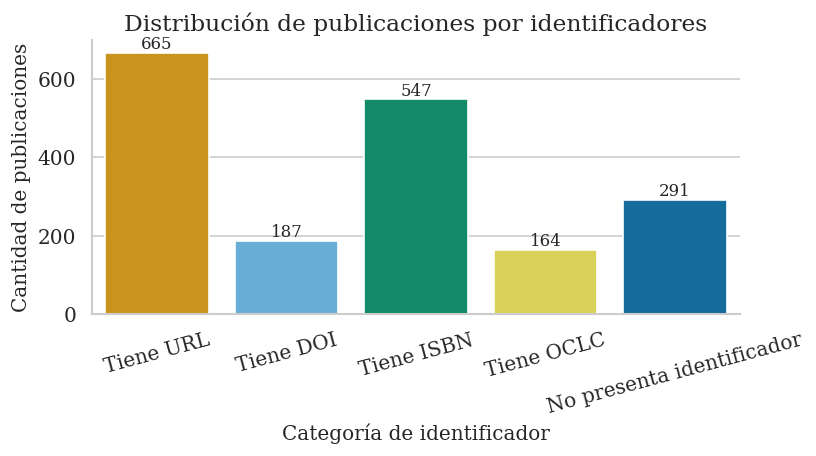

In [23]:
import matplotlib.pyplot as plt
import seaborn as sns

# Configuración global de fuentes
plt.rcParams["font.family"] = "serif"
plt.rcParams["font.serif"] = ["DejaVu Serif"]
plt.rcParams["font.size"] = 12

# ---- ESTA ES LA CLAVE ----
sns.set_theme(
    style="whitegrid",
    font_scale=1.1,
    rc={
        "font.family": "serif",
        "font.serif": ["DejaVu Serif"]
    }
)

# Paleta Okabe–Ito
okabe_ito = [
    "#E69F00", "#56B4E9", "#009E73",
    "#F0E442", "#0072B2", "#D55E00", "#CC79A7"
]

plt.figure(figsize=(7, 4), dpi=120)
palette = okabe_ito[:len(df_conteo_identificadores)]

sns.barplot(
    data=df_conteo_identificadores,
    x="Categoría",
    y="Cantidad",
    hue="Categoría",
    palette=palette,
    legend=False
)

plt.title("Distribución de publicaciones por identificadores", fontsize=14)
plt.xlabel("Categoría de identificador", fontsize=12)
plt.ylabel("Cantidad de publicaciones", fontsize=12)
plt.xticks(rotation=15)

for index, value in enumerate(df_conteo_identificadores["Cantidad"]):
    plt.text(index, value + 0.5, str(value),
             ha='center', va='bottom',
             fontsize=10)

sns.despine()
plt.tight_layout()
plt.show()


In [24]:
def has_doi_only(row):
    has_doi = False
    has_url = False

    extra_field = row.get("extra")
    if isinstance(extra_field, str) and "doi:" in extra_field.lower():
        has_doi = True

    url_field = row.get("url")
    if pd.notna(url_field) and isinstance(url_field, str) and url_field.strip() != "":
        has_url = True

    return has_doi and not has_url

# Apply the filter function to the DataFrame
df_doi_only = df[df.apply(has_doi_only, axis=1)].copy()

# Display relevant columns for the filtered items
print(f"Publicaciones con solo DOI (y no URL): {len(df_doi_only)}")
if not df_doi_only.empty:
    display(df_doi_only[["titulo", "extra", "url"]])
else:
    print("No se encontraron publicaciones que cumplan este criterio.")

Publicaciones con solo DOI (y no URL): 0
No se encontraron publicaciones que cumplan este criterio.


Conteo de bibliografía por idioma unificado:


,Cantidad,count
0,Desconocido,505
1,Inglés,441
2,Español,224
3,Indefinido,2
4,Ruso,2
5,esp,1
6,spanish,1
7,Catalán,1


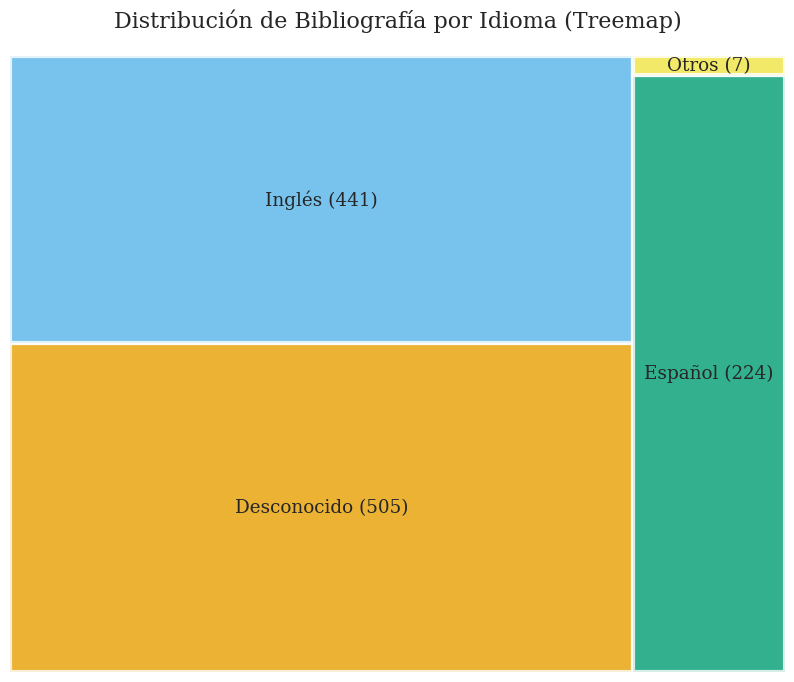

In [25]:
import matplotlib.pyplot as plt
import pandas as pd
import squarify # Importar squarify

# Diccionario para mapear las variaciones de idioma a una forma estandarizada
# Puedes agregar más mapeos si identificas otras variaciones en tus datos
mapeo_idiomas = {
    'spa': 'Español',
    'es': 'Español',
    'Español': 'Español',
    'español': 'Español',
    'es-MX': 'Español',
    'es-es': 'Español',
    'eng': 'Inglés',
    'en': 'Inglés',
    'English': 'Inglés',
    'english': 'Inglés',
    'en-US': 'Inglés',
    'EN': 'Inglés',
    'Inglés': 'Inglés',
    'und': 'Indefinido', # Unidentified
    'rus': 'Ruso',
    'ca': 'Catalán',
    '': 'Desconocido', # Empty strings
    None: 'Desconocido' # None values
}

# Aplicar el mapeo a la columna 'language'
# Usamos .map() y fillna() para manejar valores que no están en el diccionario o son nulos después del mapeo
df['language_unified'] = df['language'].map(mapeo_idiomas).fillna(df['language'].fillna('Desconocido'))

# Contar las publicaciones por idioma unificado
conteo_idiomas_unificado = df['language_unified'].value_counts().sort_values(ascending=False)

# Mostrar el conteo unificado
print("Conteo de bibliografía por idioma unificado:")
display(conteo_idiomas_unificado.reset_index().rename(columns={'index': 'Idioma', 'language_unified': 'Cantidad'}))

# Ahora generamos la gráfica de treemap con los idiomas unificados

# Calcular porcentajes (opcional, para usar umbral si se desea)
porcentajes_idiomas_unificado = conteo_idiomas_unificado / conteo_idiomas_unificado.sum() * 100

# Filtrar idiomas con porcentaje muy bajo para no saturar el gráfico (opcional)
umbral_porcentaje = 1 # Puedes ajustar este umbral
conteo_idiomas_filtrado_unificado = conteo_idiomas_unificado[porcentajes_idiomas_unificado > umbral_porcentaje]

# Si hay idiomas que quedaron fuera, sumar sus conteos en "Otros"
if len(conteo_idiomas_unificado) > len(conteo_idiomas_filtrado_unificado):
    otros_conteo = conteo_idiomas_unificado[porcentajes_idiomas_unificado <= umbral_porcentaje].sum()
    if otros_conteo > 0:
        # Crear una serie temporal para 'Otros' para poder concatenar y mantener el tipo
        otros_series = pd.Series({'Otros': otros_conteo})
        conteo_idiomas_filtrado_unificado = pd.concat([conteo_idiomas_filtrado_unificado, otros_series])

# Paleta Okabe-Ito (segura para daltónicos)
okabe_ito = [
    "#E69F00",  # Orange
    "#56B4E9",  # Sky Blue
    "#009E73",  # Bluish Green
    "#F0E442",  # Yellow
    "#0072B2",  # Blue
    "#D55E00",  # Vermilion
    "#CC79A7"   # Reddish Purple
]

# Convertir el diccionario a listas para squarify
sizes = list(conteo_idiomas_filtrado_unificado.values)
labels = [f'{k} ({v})' for k, v in conteo_idiomas_filtrado_unificado.items()]

plt.figure(figsize=(10, 8))
squarify.plot(
    sizes=sizes,
    label=labels,
    color=okabe_ito[:len(sizes)], # Usar la paleta Okabe-Ito
    alpha=0.8,
    bar_kwargs={'linewidth': 3, 'edgecolor': 'white'} # Espacio entre los rectángulos
)

plt.title("Distribución de Bibliografía por Idioma (Treemap)", fontsize=16, pad=20)
plt.axis('off') # Ocultar ejes
plt.show()


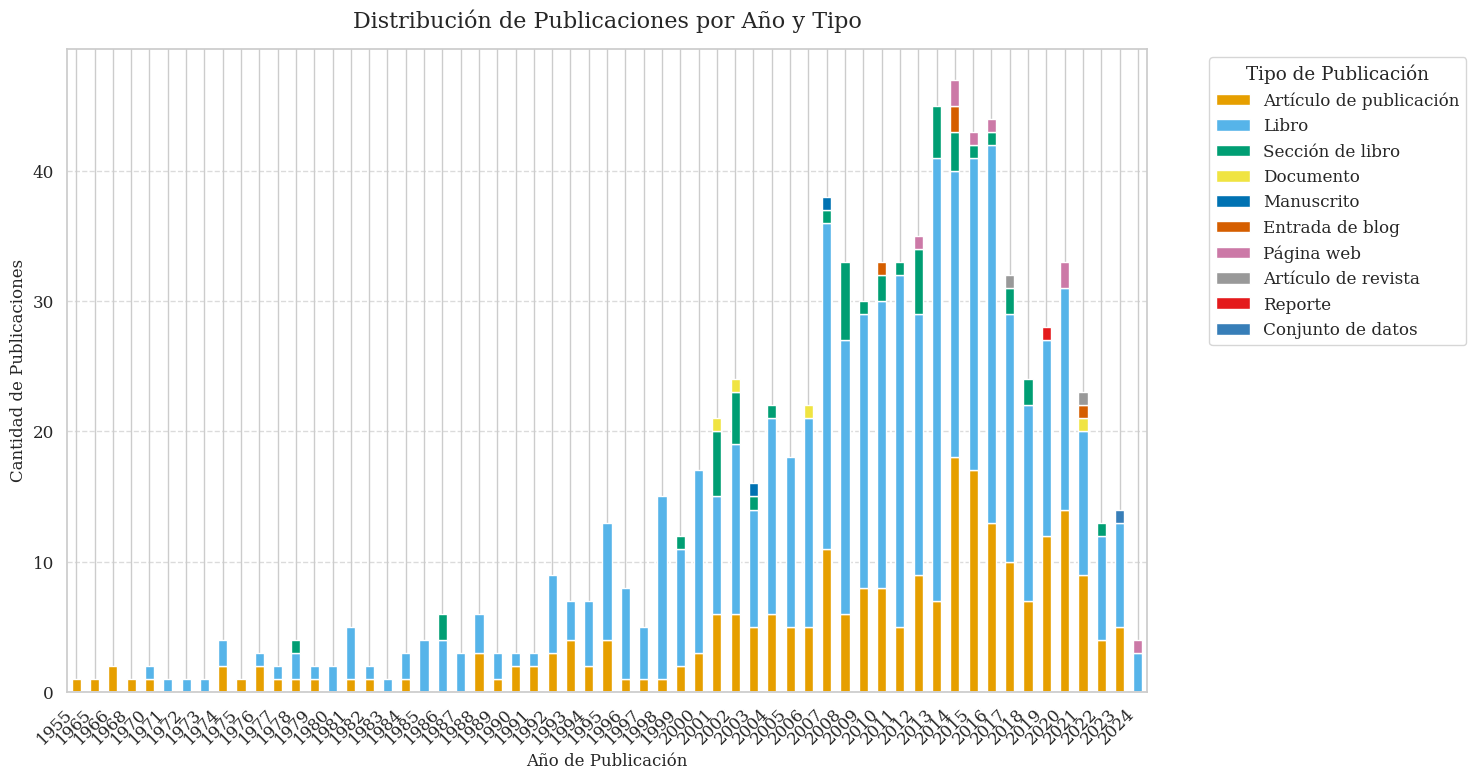

In [26]:
import matplotlib.pyplot as plt
import pandas as pd
import re
import numpy as np

# Asegurarse de que la columna 'año' esté disponible y sea numérica
def extraer_anio(fecha_texto):
    if not isinstance(fecha_texto, str):
        return np.nan
    match = re.search(r"\b(19|20)\d{2}\b", fecha_texto)
    return int(match.group()) if match else np.nan

if 'año' not in df.columns:
    df["año"] = df["fecha_publicacion"].apply(extraer_anio)

# Mapeo de tipos de Zotero a nombres en español para la leyenda
mapeo_tipos_espanol = {
    'report': 'Reporte',
    'videoRecording': 'Grabación de video',
    'dataset': 'Conjunto de datos',
    'manuscript': 'Manuscrito',
    'magazineArticle': 'Artículo de revista',
    'blogPost': 'Entrada de blog',
    'document': 'Documento',
    'attachment': 'Adjunto',
    'webpage': 'Página web',
    'bookSection': 'Sección de libro',
    'journalArticle': 'Artículo de publicación',
    'note': 'Nota',
    'book': 'Libro'
}

# Aplicar el mapeo a la columna 'tipo' si existe
if 'tipo' in df.columns:
    df['tipo_espanol'] = df['tipo'].map(mapeo_tipos_espanol).fillna(df['tipo']) # Usar el original si no hay mapeo

    # Agrupar por año y por tipo de publicación en español, y contar
    conteo_por_anio_tipo_pub = df.groupby(["año", "tipo_espanol"]).size().unstack(fill_value=0)

    # Eliminar filas con año nulo
    conteo_por_anio_tipo_pub = conteo_por_anio_tipo_pub[conteo_por_anio_tipo_pub.index.notnull()]

    # Asegurarse de que los años sean enteros para el eje x
    conteo_por_anio_tipo_pub.index = conteo_por_anio_tipo_pub.index.astype(int)

    # Ordenar por año
    conteo_por_anio_tipo_pub = conteo_por_anio_tipo_pub.sort_index()

    # Paleta Okabe-Ito (segura para daltónicos) - Extendemos si es necesario
    okabe_ito_extended = [
        "#E69F00", "#56B4E9", "#009E73", "#F0E442", "#0072B2", "#D55E00", "#CC79A7",
        "#999999", "#E41A1C", "#377EB8", "#4DAF4A", "#984EA3", "#FF7F00" # Algunos colores adicionales si hay muchos tipos
    ]

    # Seleccionar colores de la paleta extendida según la cantidad de tipos
    colores_grafica_tipos = okabe_ito_extended[:len(conteo_por_anio_tipo_pub.columns)]


    # Crear el gráfico de barras apiladas
    plt.figure(figsize=(15, 8)) # Aumentar tamaño
    conteo_por_anio_tipo_pub.plot(kind='bar', stacked=True, figsize=(15, 8), color=colores_grafica_tipos, ax=plt.gca())


    plt.title("Distribución de Publicaciones por Año y Tipo", fontsize=16, pad=15)
    plt.xlabel("Año de Publicación", fontsize=12)
    plt.ylabel("Cantidad de Publicaciones", fontsize=12)
    plt.legend(title="Tipo de Publicación", bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.grid(axis="y", linestyle="--", alpha=0.7)
    plt.xticks(rotation=45, ha='right') # Rotar etiquetas del eje X para mejor legibilidad
    plt.tight_layout()
    plt.show()

else:
    print("⚠️ No se encontró la columna 'tipo'. Asegúrate de incluir item_data.get('itemType') en el diccionario.")